<a href="https://colab.research.google.com/github/ShynPham/food-classification/blob/main/FoodVision101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing all the necessary library

In [1]:

# Importing nesseary library
import torch
import torchvision
import gradio

from torch import nn
from torchvision import datasets
from pathlib import Path
from torchvision import transforms

# Download torchinfo if haven't download yuet
try:
  import torchinfo
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install torchinfo
  import torchinfo
  from torchinfo import summary
# Checkout the version of torch
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Gradio version: {gradio.__version__}")
print(f"Torchinfo version: {torchinfo.__version__}")

[INFO] Couldn't find torchinfo... installing it.
Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Gradio version: 5.42.0
Torchinfo version: 1.8.0


In [2]:
# Download the going_modular directory from github
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going_modular srcipts
  print(f"[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from github")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from github
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


# 1.1 Setting up device aconogstic


In [3]:
# Setup device acognistic
device  = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

# 2. Download Food101 data and split it into test and train data


Before download Food101 datasets, we will perform data augmenatation on data.
> ***Data augmentation*** is a technique used to artificially increase the size and diversity of a training dataset by creating modified copies of existing data.

And we will also create an ViT model extractor and that capable of fitting 101 classes for Food101

## 2.1 Create ViT model extractor

In [4]:
import torch
import torchvision
from torch import nn

def create_vit_model(num_classes: int = 101,
                     seed: int = 42,
                     fine_tune_layers: int = 0) -> tuple[torch.nn.Module, torchvision.transforms.Compose]:
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 101.
        seed (int, optional): random seed value for output layer. Defaults to 42.
        fine_tune_layers (int, optional): number of layers to unfreeze for fine-tuning.
                                          Defaults to 0 (only classifier head is trained).

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model initially
    for param in model.parameters():
        param.requires_grad = False

    # # Unfreeze the specified number of layers from the end of the feature extractor
    # if fine_tune_layers > 0:
    #     # Get the list of layers in the encoder
    #     encoder_layers = list(model.encoder.children())
    #     # Determine how many layers to unfreeze from the end
    #     num_encoder_layers = len(encoder_layers)
    #     layers_to_unfreeze = encoder_layers[num_encoder_layers - fine_tune_layers:]

    #     for layer in layers_to_unfreeze:
    #         for param in layer.parameters():
    #             param.requires_grad = True

    # Change classifier head to suit our needs (this will always be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [5]:
# Create an ViT model capable of fitting 1010 classes for Food101
# Apply fine_tune_layers here to unfreeze a specified number of encoder layers
vit_food101, vit_transforms = create_vit_model(num_classes=101,
                                               seed=42)
                                              #  fine_tune_layers=2 # Example: fine-tune the last 2 encoder layers

# Move the model to the target device
vit_food101.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 96.2MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [6]:
# Get the summary of the model
from torchinfo import summary
summary(vit_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],

)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

# 2.2 Code to perofrm data augmenation on data

For ViT model, we will use TrivivalAgumentationWide(), which translate to:
```
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225
```
these value are the exact replicated from [ViT paper](https://arxiv.org/pdf/2010.11929)

In [7]:
# Create training transforms that only perform on training images
food101_train_transforms = transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

In [8]:
# Check out test and train data
print(f"Food101 train transforms: {food101_train_transforms}")
print(f"Food101 test transforms: {vit_transforms}")

Food101 train transforms: Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)
Food101 test transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## 2.3 Download and split the datasets into train and test


## 2.3.1 First download the train and test datasets

In [9]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms, # perform normal ViT transforms on test data
                             download=True)

100%|██████████| 5.00G/5.00G [04:57<00:00, 16.8MB/s]


In [10]:
food101_class_names = train_data.classes
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## 2.3.2 Create new folder for train and test datasets

In [11]:
# # Define Path
# from pathlib import Path

# # Setup up paths for train and test
# data_dir = Path("/content/data/food-101")
# source_image_dir = data_dir / "images"
# train_list_path = data_dir / "meta" / "train.txt"
# test_list_path = data_dir / "meta" / "test.txt"
# target_train_dir = data_dir / "train"
# target_test_dir = data_dir / "test"


# print(f"Data directory: {data_dir}")
# print(f"Source images directory: {source_image_dir}")
# print(f"Train list path: {train_list_path}")
# print(f"Test list path: {test_list_path}")
# print(f"Target train directory: {target_train_dir}")
# print(f"Target test directory: {target_test_dir}")

In [12]:
# # Create target directories if they don't exist
# target_train_dir.mkdir(parents=True, exist_ok=True)
# target_test_dir.mkdir(parents=True, exist_ok=True)

# print(f"Created train directory at: {target_train_dir}")


# print(f"Created test directory at: {target_test_dir}")

## 2.3.3 Split train and test data into folders


In [13]:
# # Read all images in train path
# with open(train_list_path, "r") as file:
#     train_image_paths = file.readlines()
# # Read all test image path
# with open(test_list_path, "r") as file:
#     test_image_paths = file.readlines()

# # Print out the number of images paths
# print(f"Number of train images: {len(train_image_paths)}")
# print(f"Number of test images: {len(test_image_paths)}")

In [14]:
# import shutil
# import os

# # Function to copy images based on a list of paths
# def copy_images(image_paths, source_dir, target_dir):
#     for image_path in image_paths:
#         # Remove potential newline characters from the end of the path
#         image_path = image_path.strip()
#         source_path = source_dir / (image_path + ".jpg")
#         destination_path = target_dir / (image_path + ".jpg")

#         # Create parent directories if they don't exist
#         destination_path.parent.mkdir(parents=True, exist_ok=True)

#         try:
#             shutil.copy2(source_path, destination_path)
#         except FileNotFoundError:
#             print(f"Warning: File not found at {source_path}. Skipping.")


# # Copy train images
# print("Copying train images...")
# copy_images(train_image_paths, source_image_dir, target_train_dir)
# print("Train image copying complete.")

# # Copy test images
# print("Copying test images...")
# copy_images(test_image_paths, source_image_dir, target_test_dir)
# print("Test image copying complete.")

In [15]:
# # Count files in target train and test directories
# train_file_count = len(list(target_train_dir.rglob("*.jpg")))
# test_file_count = len(list(target_test_dir.rglob("*.jpg")))

# print(f"Number of files in the training directory: {train_file_count}")
# print(f"Number of files in the testing directory: {test_file_count}")

# # Compare with the number of paths read from the text files
# print(f"Number of paths read from train.txt: {len(train_image_paths)}")
# print(f"Number of paths read from test.txt: {len(test_image_paths)}")

# 3. Turn Food101 datasets into `DataLoader`s

In [16]:
import os
import torch

train_datalaoder_food101 = torch.utils.data.DataLoader(dataset=train_data,
                                                       batch_size=32,
                                                       shuffle=True,
                                                       num_workers=os.cpu_count())
test_dataloader_food101 = torch.utils.data.DataLoader(dataset=test_data,
                                                      batch_size=32,
                                                      shuffle=False,
                                                      num_workers=os.cpu_count())

# 4. Train

## 4.1 Setup optimizer and loss function

In [17]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

## 4.2 Setup save and load checkpoint for each iteration


In [18]:
import torch
import os

def save_checkpoint(model, optimizer, epoch, loss, save_dir="checkpoints"):
    """Saves the model and optimizer states as a checkpoint.

    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer to save.
        epoch (int): The current epoch number.
        loss (float): The current loss value.
        save_dir (str): The directory to save the checkpoint in.
    """
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch}.pth")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint for epoch {epoch} saved to {checkpoint_path}")

In [19]:
import torch
import os

def load_checkpoint(checkpoint_path, model, optimizer=None):
    """Loads a checkpoint and restores model and optimizer states.

    Args:
        checkpoint_path (str): The path to the checkpoint file.
        model (torch.nn.Module): The model to load the state into.
        optimizer (torch.optim.Optimizer, optional): The optimizer to load the state into.
                                                     Defaults to None.

    Returns:
        int: The epoch number from the checkpoint.
        float: The loss value from the checkpoint.
    """
    if not os.path.exists(checkpoint_path):
        print(f"Error: Checkpoint file not found at {checkpoint_path}")
        return None, None

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"Checkpoint loaded successfully from {checkpoint_path}")
    print(f"Resuming from epoch {epoch} with loss {loss}")

    return epoch, loss

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Trains a model for one epoch."""
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across the batch
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    """Tests a model for one epoch."""
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through data loader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy metric across the batch
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(
                test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [23]:
from tqdm.auto import tqdm
import os # Import os for creating the save directory
import glob # Import glob for finding files

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          save_dir: str = "checkpoints"): # Add save_dir argument
    """Trains and tests a PyTorch model with checkpointing.

    Args:
        model (torch.nn.Module): Instance of the model to be trained and tested.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for the testing data.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        loss_fn (torch.nn.Module): Loss function to use for training.
        epochs (int): Number of epochs to train for.
        device (torch.device): Device to train on (e.g., "cuda" or "cpu").
        save_dir (str): Directory to save checkpoints.
    Returns:
        dict: A dictionary containing training and testing loss and accuracy values.
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    #Put model into target device
    model.to(device)
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Check for existing checkpoints and load the latest one
    latest_checkpoint = None
    list_of_checkpoints = glob.glob(os.path.join(save_dir, "checkpoint_epoch_*.pth"))
    if list_of_checkpoints:
        # Find the latest checkpoint based on epoch number in filename
        latest_checkpoint_path = max(list_of_checkpoints, key=os.path.getctime) # Using ctime for simplicity, might need to parse epoch number for robustness
        print(f"Found existing checkpoint: {latest_checkpoint_path}")
        # Load the checkpoint
        checkpoint = torch.load(latest_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None:
             optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        start_epoch = checkpoint['epoch']
        loaded_loss = checkpoint['loss'] # You might also want to load other metrics if saved in checkpoint

        # Attempt to load historical results from the checkpoint if they were saved
        if 'results' in checkpoint:
            results = checkpoint['results']
            print("Loaded historical results from checkpoint.")
        else:
             print("No historical results found in checkpoint. Starting new results tracking.")

        start_epoch += 1 # Resume from the next epoch
        print(f"Resuming from epoch {start_epoch} with loss {loaded_loss}")
    else:
        start_epoch = 0
        print("No existing checkpoints found. Starting training from epoch 0.")

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(start_epoch, epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Save checkpoint at the end of each epoch, including results
        save_checkpoint(model=model,
                          optimizer=optimizer,
                          epoch=epoch + 1, # Save with 1-based epoch number
                          loss=test_loss, # You could save train_loss or test_loss
                          save_dir=save_dir)


    # Return the filled results dictionary
    return results

In [25]:
# Training time
set_seeds()
vit_food101_result = train(model=vit_food101,
                           train_dataloader=train_datalaoder_food101,
                           test_dataloader=test_dataloader_food101,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=5,
                           device=device)

Found existing checkpoint: checkpoints/checkpoint_epoch_5.pth
No historical results found in checkpoint. Starting new results tracking.
Resuming from epoch 6 with loss 0.8763037349795922


0it [00:00, ?it/s]

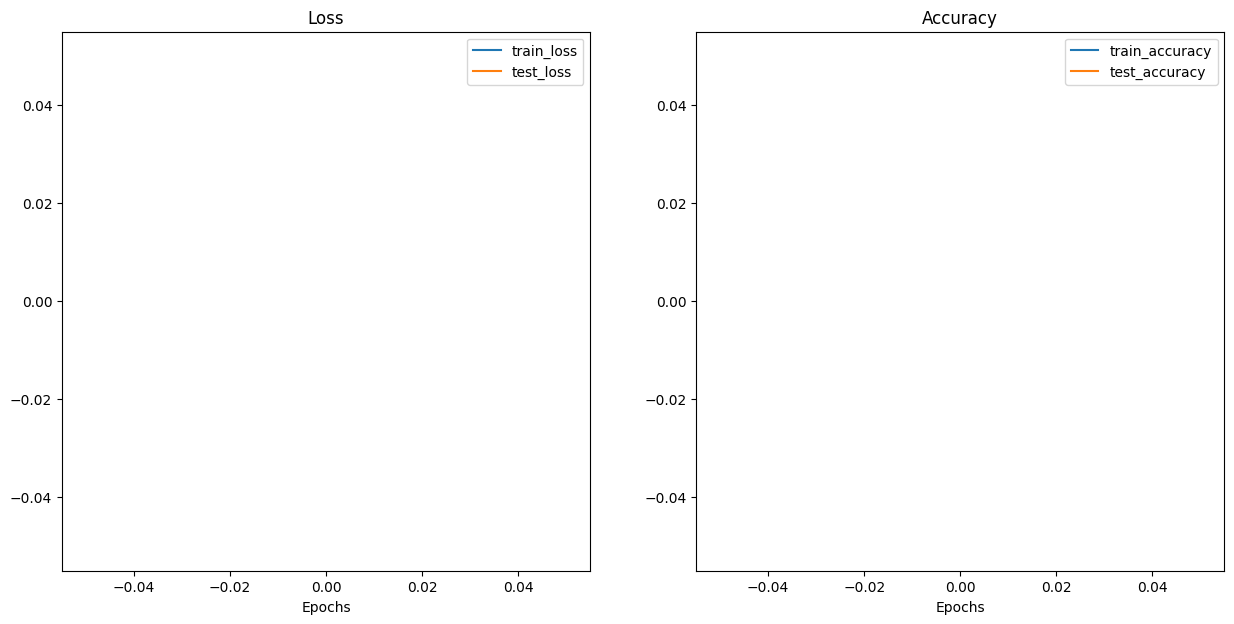

In [26]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_food101_result)

# 5. Saving and loading FoodVision101


In [27]:
from going_modular.going_modular import utils

# Create a model path
vit_food101_result =  "ViT_Food101_results.pth"
# Save the model
utils.save_model(model=vit_food101,
                 target_dir="models",
                 model_name=vit_food101_result)


[INFO] Saving model to: models/ViT_Food101_results.pth


Checking if food101 instances is match with state dict())

In [28]:
loaded_vit_food101, vit_transforms = create_vit_model(num_classes=101)

loaded_vit_food101.load_state_dict(torch.load("models/ViT_Food101_results.pth"))

<All keys matched successfully>

Test model with random images

In [29]:
from pathlib import Path

# Get all test data images
# Construct the path to the test images directory
test_images_dir = Path(test_data.root) / "food-101" / "images"
print(f"[INFO] Finding all filepath ending with .jpg in directory {test_images_dir}")
test_image_paths = list(test_images_dir.glob("*/*.jpg"))
test_image_paths[:10]

[INFO] Finding all filepath ending with .jpg in directory data/food-101/images


[PosixPath('data/food-101/images/french_toast/664180.jpg'),
 PosixPath('data/food-101/images/french_toast/1278221.jpg'),
 PosixPath('data/food-101/images/french_toast/1057911.jpg'),
 PosixPath('data/food-101/images/french_toast/1949132.jpg'),
 PosixPath('data/food-101/images/french_toast/2092531.jpg'),
 PosixPath('data/food-101/images/french_toast/1060359.jpg'),
 PosixPath('data/food-101/images/french_toast/1139825.jpg'),
 PosixPath('data/food-101/images/french_toast/288623.jpg'),
 PosixPath('data/food-101/images/french_toast/3513562.jpg'),
 PosixPath('data/food-101/images/french_toast/290224.jpg')]

In [30]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)



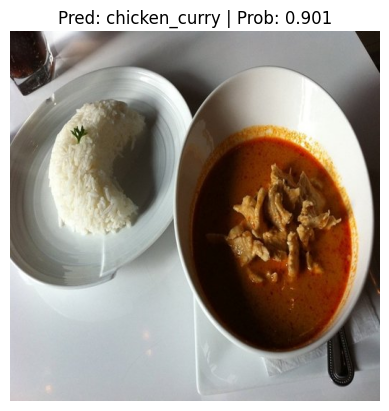

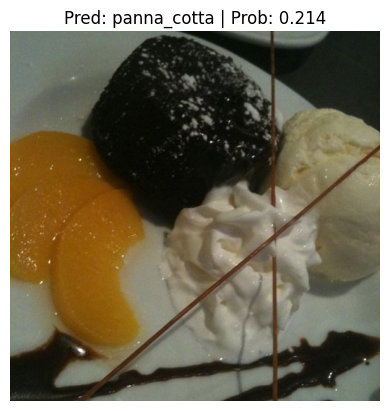

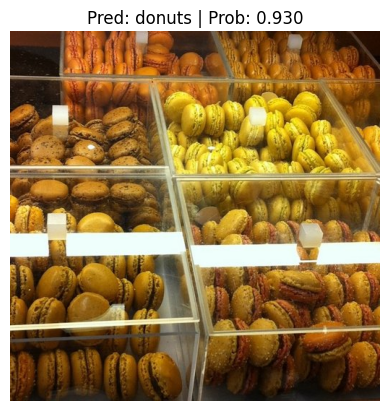

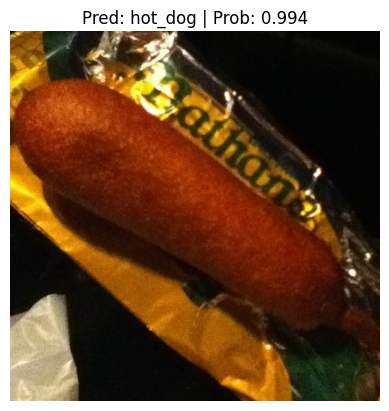

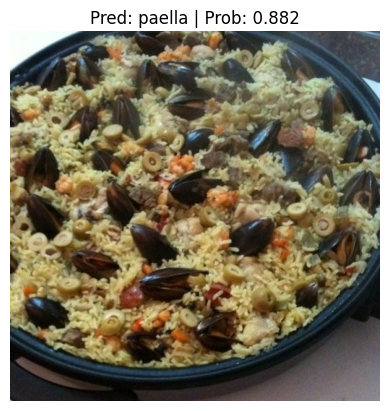

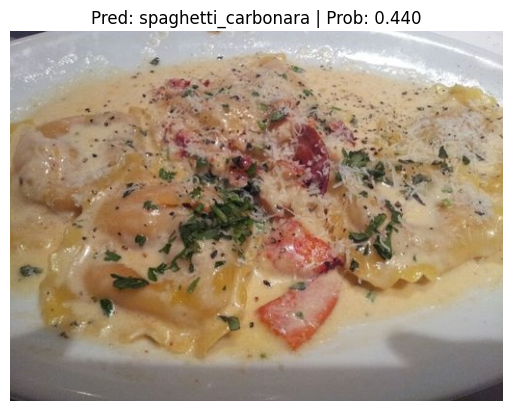

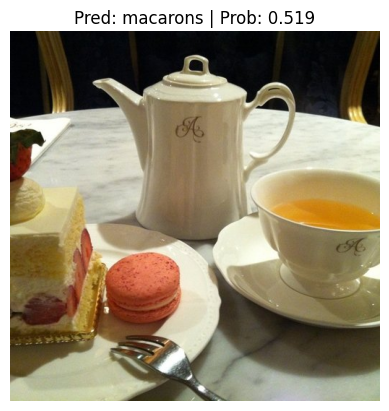

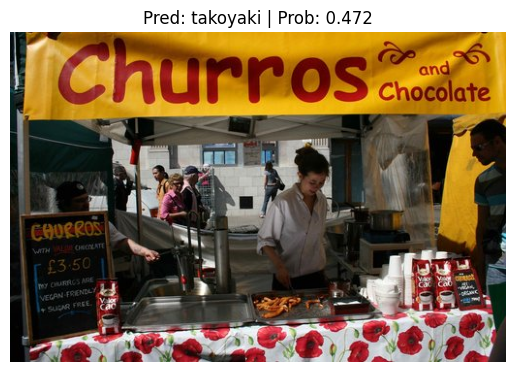

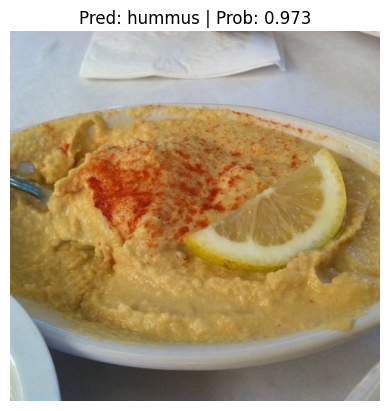

In [31]:
import random

# Get a random sample of image paths (adjust k to the number of images you want to predict on)
random_image_paths = random.sample(test_image_paths, k=9) # Choose 9 random images

# Predict and plot for each image in the sample
for image_path in random_image_paths:
    pred_and_plot_image(model=vit_food101, # Use your trained m|odel
                        image_path=image_path, # Pass a single image path
                        image_size=(224, 224),
                        transform=vit_transforms,
                        class_names=food101_class_names, # Ensure class_names is defined
                        device=device) # Ensure device is defined

# 5. Turn food101 into deployable app


In [32]:
from pathlib import Path
# Create Food101 demo path
food101_demo_path = Path("demos/food101")
# Make Food101 demo directory
food101_demo_path.mkdir(parents=True, exist_ok=True)
#Make Food101 examples directory
(food101_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [33]:
examples_path = food101_demo_path / "examples"
examples_path

PosixPath('demos/food101/examples')

In [34]:
# import shutil
# from pathlib import Path

# # Define the path to the examples folder
# examples_path = Path("demos/food101/examples")

# # Check if the folder exists before attempting to delete
# if examples_path.exists() and examples_path.is_dir():
#     print(f"Deleting examples folder at: {examples_path}")
#     shutil.rmtree(examples_path)
#     print("Examples folder deleted.")
# else:
#     print(f"Examples folder not found at: {examples_path}")

In [35]:
# import shutil
# import os
# from pathlib import Path # Ensure Path is imported if not already

# # Ensure the examples directory exists
# examples_path.mkdir(parents=True, exist_ok=True)

# print("Moving test images to examples folder...")

# # Loop through the list of test image paths (which are already in the test directory)
# for image_path in test_image_paths:
#     # The source path is the current path of the image in the test directory
#     source_path = image_path

#     # Construct the destination path relative to the test directory to maintain class structure
#     destination_path = examples_path / image_path.relative_to(target_test_dir)

#     # Create parent directories in the examples folder if they don't exist
#     destination_path.parent.mkdir(parents=True, exist_ok=True)

#     try:
#         # Move the file
#         shutil.move(source_path, destination_path)
#     except FileNotFoundError:
#         print(f"Warning: File not found at {source_path}. Skipping.")
#     except Exception as e:
#         print(f"Error moving {source_path} to {destination_path}: {e}")


# print("Test image moving complete.")

In [36]:
# Saving class_names to file
food101_class_names_path = food101_demo_path / "class_names.txt"

with open(food101_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {food101_class_names_path}")
  f.write("\n".join(food101_class_names))

[INFO] Saving Food101 class names to demos/food101/class_names.txt


In [37]:
# Open Food101 class name file and read each line to a list
with open(food101_class_names_path, "r") as f:
    class_names = f.read().split("\n")
class_names[:4]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio']

# 6. Inspect through Gradio


## 6.1 Creating a function to map our inputs and outputs

In [38]:
vit_food101.to(device)

next(iter(vit_food101.parameters())).device

device(type='cuda', index=0)

In [39]:
from typing import Tuple, Dict
from timeit import default_timer as timer
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = vit_transforms(img).unsqueeze(0)

    # Move the image tensor to the target device
    img = img.to(device)

    # Put model into evaluation mode and turn on inference mode
    vit_food101.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit_food101(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [40]:
import glob
import random
import shutil
import os
from pathlib import Path

# Define the path to the data directory
data_directory = Path("/content/data/food-101")
test_list_path = data_directory / "meta" / "test.txt"
source_image_dir = data_directory / "images"

# Collect all test image paths from test.txt
all_test_image_paths = []
if test_list_path.exists():
    print(f"[INFO] Reading test image paths from {test_list_path}")
    with open(test_list_path, "r") as f:
        for line in f:
            image_path_relative = line.strip()
            full_image_path = source_image_dir / (image_path_relative + ".jpg")
            if full_image_path.exists():
                all_test_image_paths.append(full_image_path)
            else:
                print(f"Warning: Test image file not found at {full_image_path}. Skipping.")
    print(f"[INFO] Found {len(all_test_image_paths)} test images.")
else:
    print(f"Error: Test list file not found at {test_list_path}")


# Determine the number of examples to sample (ensure k is not larger than the population)
k_samples = min(10, len(all_test_image_paths)) # Sample at most 10 images or the number of available images

if all_test_image_paths and k_samples > 0:
    # Collect a few random test data images
    random_test_images = random.sample(all_test_image_paths, k=k_samples)

    # Ensure the examples directory exists (recreate if necessary to clear previous examples)
    examples_path = food101_demo_path / "examples"
    if examples_path.exists():
      print(f"[INFO] Clearing existing examples directory at {examples_path}")
      shutil.rmtree(examples_path)
    examples_path.mkdir(parents=True, exist_ok=True)

    # Copy the images to the examples folder
    print(f"[INFO] Copying {len(random_test_images)} random test images to {examples_path}...")
    for image_path in random_test_images:
        try:
            shutil.copy(image_path, examples_path / image_path.name)
        except FileNotFoundError:
            print(f"Warning: File not found at {image_path}. Skipping during copy.")
        except Exception as e:
            print(f"Error copying {image_path} to {examples_path / image_path.name}: {e}")

    print(f"[INFO] Finished copying random test images.")
    # Verify copied files
    copied_files = list(examples_path.glob('*.jpg'))
    print(f"[INFO] {len(copied_files)} images copied to {examples_path}.")
    if copied_files:
        print(f"First {min(5, len(copied_files))} copied image filenames: {[path.name for path in copied_files][:min(5, len(copied_files))]}")

else:
    print("No test images found or no test images could be sampled. Cannot copy examples.")

[INFO] Reading test image paths from /content/data/food-101/meta/test.txt
[INFO] Found 25250 test images.
[INFO] Clearing existing examples directory at demos/food101/examples
[INFO] Copying 10 random test images to demos/food101/examples...
[INFO] Finished copying random test images.
[INFO] 10 images copied to demos/food101/examples.
First 5 copied image filenames: ['2061495.jpg', '204042.jpg', '2836188.jpg', '2937793.jpg', '2802278.jpg']


In [41]:
import random
from PIL import Image
from pathlib import Path # Import Path

# Get a list of all test image filepaths from the previously created list
if 'all_test_image_paths' in locals() and all_test_image_paths:
    # Randomly select a test image path
    random_image_path = random.sample(all_test_image_paths, k=1)[0]

    # Open the target image
    image = Image.open(random_image_path)
    print(f"[INFO] Predicting on image at path: {random_image_path}\n")

    # Predict on the target image and print out the outputs
    pred_dict, pred_time = predict(img=image)
    print(f"Prediction label and probability dictionary: \n{pred_dict}")
    print(f"Prediction time: {pred_time} seconds")
else:
    print("Error: 'all_test_image_paths' not found or is empty. Please ensure the cell to collect test image paths has been executed successfully.")

[INFO] Predicting on image at path: /content/data/food-101/images/miso_soup/3619222.jpg

Prediction label and probability dictionary: 
{'apple_pie': 4.6212568349801586e-07, 'baby_back_ribs': 1.5669722870370606e-06, 'baklava': 7.825653369764041e-08, 'beef_carpaccio': 2.0668957745328953e-07, 'beef_tartare': 1.5874560688189376e-07, 'beet_salad': 8.379299174521293e-07, 'beignets': 2.1031360120105091e-07, 'bibimbap': 1.0549167654971825e-06, 'bread_pudding': 1.532899659650866e-06, 'breakfast_burrito': 8.097103432191943e-07, 'bruschetta': 1.7626662796033088e-08, 'caesar_salad': 1.0727557508971586e-07, 'cannoli': 5.293668081662872e-08, 'caprese_salad': 2.910623777552246e-07, 'carrot_cake': 1.8140915472031338e-06, 'ceviche': 5.668574431183515e-06, 'cheese_plate': 4.769445240526693e-06, 'cheesecake': 8.669189264765009e-05, 'chicken_curry': 0.00021804898278787732, 'chicken_quesadilla': 1.0725613464046546e-07, 'chicken_wings': 2.1670200567314168e-07, 'chocolate_cake': 1.547907231724821e-06, 'choco

In [42]:
import gradio as gr
import glob
from pathlib import Path # Import Path to work with paths

# Create a title for the
title = "Food101 Vision"
description = "ViT model extractor test"
article = "By shyn1"

# Define the path to the examples directory
examples_path = Path("demos/food101/examples")

# Get a list of all image paths in the examples directory
# Corrected glob.glob usage to find all .jpg files directly in the examples directory
food101_example_paths = glob.glob(str(examples_path / "*.jpg"))


# Format the example image paths into a nested list as required by Gradio
# Each inner list contains a single example image path
gradio_examples = [[image_path] for image_path in food101_example_paths] # Use the correctly populated list

# Check if there are any examples before creating the Gradio interface
if not gradio_examples:
    print(f"No example images found in {examples_path}. Please ensure the examples folder is populated.")
else:
    demo = gr.Interface(fn=predict,
                         inputs=gr.Image(type="pil"),
                         outputs=[gr.Label(num_top_classes=5, label="Predictions"), gr.Number(label="Prediction time (s)")],
                         title=title,
                         description=description,
                         article=article,
                         examples=gradio_examples) # Pass the formatted list of examples

    demo.launch(debug=False)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://04a6da8fc1aff10a1d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [43]:
# Move the state dict model into food101 demos folder
import shutil
from pathlib import Path

source_model_path = Path("models") / "ViT_Food101_results.pth"
food101_demo_path = Path("demos/food101")
vit_food101_model_path = food101_demo_path / "ViT_Food101_results.pth"

# Ensure the destination directory exists
food101_demo_path.mkdir(parents=True, exist_ok=True)

# Move the model file
try:
    shutil.move(source_model_path, vit_food101_model_path)
    print(f"Moved model from {source_model_path} to {vit_food101_model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {source_model_path}. Please ensure the model was saved correctly.")
except Exception as e:
    print(f"Error moving model file: {e}")

Moved model from models/ViT_Food101_results.pth to demos/food101/ViT_Food101_results.pth


# 7. Turning everything else into Python script



## 7.1 Turning model into python scrpit


In [44]:
%%writefile demos/food101/model.py

import torch
import torchvision
from torch import nn

def create_vit_model(num_classes: int = 101,
                     seed: int = 42,
                     fine_tune_layers: int = 0) -> tuple[torch.nn.Module, torchvision.transforms.Compose]:
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 101.
        seed (int, optional): random seed value for output layer. Defaults to 42.
        fine_tune_layers (int, optional): number of layers to unfreeze for fine-tuning.
                                          Defaults to 0 (only classifier head is trained).

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model initially
    for param in model.parameters():
        param.requires_grad = False

    # # Unfreeze the specified number of layers from the end of the feature extractor
    # if fine_tune_layers > 0:
    #     # Get the list of layers in the encoder
    #     encoder_layers = list(model.encoder.children())
    #     # Determine how many layers to unfreeze from the end
    #     num_encoder_layers = len(encoder_layers)
    #     layers_to_unfreeze = encoder_layers[num_encoder_layers - fine_tune_layers:]

    #     for layer in layers_to_unfreeze:
    #         for param in layer.parameters():
    #             param.requires_grad = True

    # Change classifier head to suit our needs (this will always be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

Writing demos/food101/model.py


In [45]:
%%writefile demos/food101/app.py

import gradio as gr
import os
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict
from PIL import Image # Import PIL Image
from pathlib import Path # Import Path

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Get the directory of the current script
current_dir = Path(__file__).parent

# Define paths relative to the script's directory
class_names_path = current_dir / "class_names.txt"
model_path = current_dir / "ViT_Food101_results.pth"
examples_path = current_dir / "examples"


with open(class_names_path, "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

# Create ViT model
vit_food101, vit_transforms = create_vit_model(num_classes=101,
                                              seed=42)

# Load the model state dict and move the model to the target device
vit_food101.load_state_dict(torch.load(f=model_path, map_location=torch.device(device)))
vit_food101.to(device)

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    # Ensure the image is in RGB format (some images might be grayscale)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_transformed = vit_transforms(img).unsqueeze(0)

    # Move the image tensor to the target device
    img_transformed = img_transformed.to(device)

    # Put model into evaluation mode and turn on inference mode
    vit_food101.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit_food101(img_transformed), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

import gradio as gr
import glob
from pathlib import Path # Import Path to work with paths


# Create a title for the
title = "Food101 Vision"
description = "ViT model extractor test"
article = "By shyn1"


# Get a list of all image paths in the examples directory
# Corrected glob.glob usage to find all .jpg files directly in the examples directory
food101_example_paths = glob.glob(str(examples_path / "*.jpg"))


# Format the example image paths into a nested list as required by Gradio
# Each inner list contains a single example image path
gradio_examples = [[image_path] for image_path in food101_example_paths] # Use the correctly populated list

# Check if there are any examples before creating the Gradio interface
if not gradio_examples:
    print(f"No example images found in {examples_path}. Please ensure the examples folder is populated.")
else:
    demo = gr.Interface(fn=predict,
                         inputs=gr.Image(type="pil"),
                         outputs=[gr.Label(num_top_classes=5, label="Predictions"), gr.Number(label="Prediction time (s)")],
                         title=title,
                         description=description,
                         article=article,
                         examples=gradio_examples) # Pass the formatted list of examples

    demo.launch(debug=False)

Writing demos/food101/app.py


In [ ]:
%%writefile demos/food101/requirements.txt
torch==2.6.0
torchvision==0.21.0
gradio==5.42.0

In [ ]:
!ls demos/food101